In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

ModuleNotFoundError: No module named 'sklearn'

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [6]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
len(dataset)

501

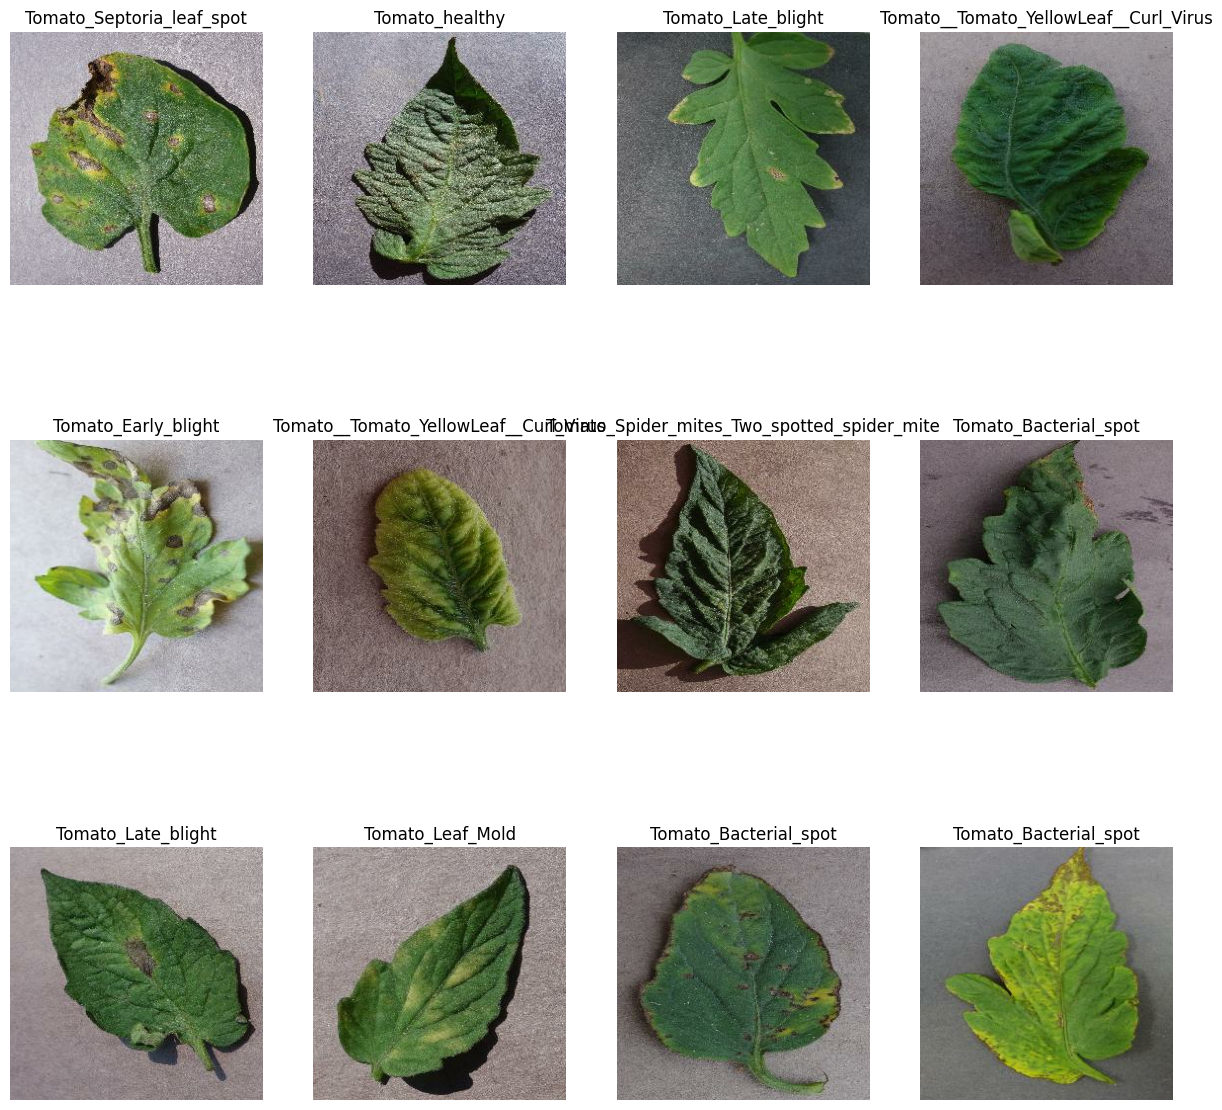

In [8]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
train_size=0.8 # 80% for training
len(dataset)*train_size

400.8

In [10]:
train_ds=dataset.take(400)
len(train_ds)

400

In [11]:
sep_ds=dataset.skip(400) #separating dataset for validation and testing
len(sep_ds)

101

In [12]:
val_size=0.1 #10% for testing and validation
len(dataset)*val_size

50.1

In [13]:
val_ds=sep_ds.take(50)
len(val_ds)

50

In [14]:
test_ds=sep_ds.skip(50)
len(test_ds)

51

In [15]:
# generalizing above calculation
def get_dataset_partition_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000 ):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12) #seed is for predictability
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, test_ds, val_ds

In [16]:
train_ds, test_ds, val_ds=get_dataset_partition_tf(dataset)

In [17]:
len(train_ds)

400

In [18]:
len(val_ds)

50

In [19]:
len(test_ds)

51

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#preprocessing
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),           #used in case during prediction of image, size is not 256x256(like in the dataset)
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
#data augmentation
data_aug=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=10

model=models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
with tf.device('/GPU:0'):
    history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    )

Epoch 1/50
400/400 [==============================] - 91s 226ms/step - loss: 1.7012 - accuracy: 0.3851 - val_loss: 1.5988 - val_accuracy: 0.4625
Epoch 2/50
400/400 [==============================] - 57s 141ms/step - loss: 0.9983 - accuracy: 0.6431 - val_loss: 0.9699 - val_accuracy: 0.6619
Epoch 3/50
400/400 [==============================] - 42s 106ms/step - loss: 0.6855 - accuracy: 0.7537 - val_loss: 1.4994 - val_accuracy: 0.5763
Epoch 4/50
400/400 [==============================] - 43s 107ms/step - loss: 0.5456 - accuracy: 0.8102 - val_loss: 1.3171 - val_accuracy: 0.6306
Epoch 5/50
400/400 [==============================] - 42s 106ms/step - loss: 0.4232 - accuracy: 0.8500 - val_loss: 0.7696 - val_accuracy: 0.7613
Epoch 6/50
400/400 [==============================] - 43s 107ms/step - loss: 0.3591 - accuracy: 0.8717 - val_loss: 0.7574 - val_accuracy: 0.7694
Epoch 7/50
400/400 [==============================] - 48s 121ms/step - loss: 0.3297 - accuracy: 0.8850 - val_loss: 0.6759 - val_ac

In [32]:
scores=model.evaluate(test_ds)

51/51 [==============================] - 27s 32ms/step - loss: 0.1244 - accuracy: 0.9638


In [33]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [36]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

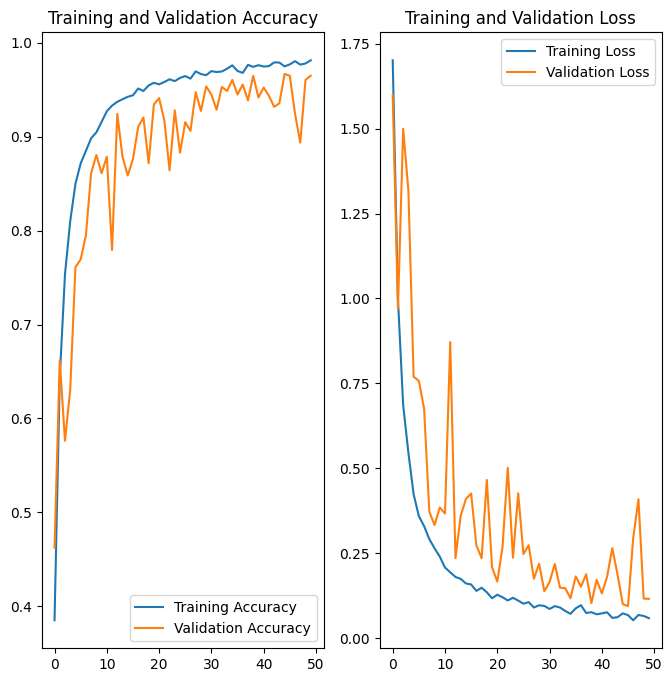

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
# ---------- ADD THIS CODE FOR ADDITIONAL EVALUATION ---------- #
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Get True Labels & Predictions
true_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    batch_predictions = model.predict(images_batch)  # Get predictions
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)  # Convert to class indices
    
    true_labels.extend(labels_batch.numpy())  # Append true labels
    predicted_labels.extend(batch_predicted_labels)  # Append predicted labels

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Precision, Recall, and F1 Score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(len(class_names)))
predicted_probs = model.predict(test_ds.map(lambda x, y: x))  # Get probability predictions

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()
# ---------- END OF EVALUATION CODE ---------- #

first image to predict
actual label:  Tomato_Bacterial_spot
1/1 [==============================] - 0s 29ms/step
predicted label: Tomato_Bacterial_spot


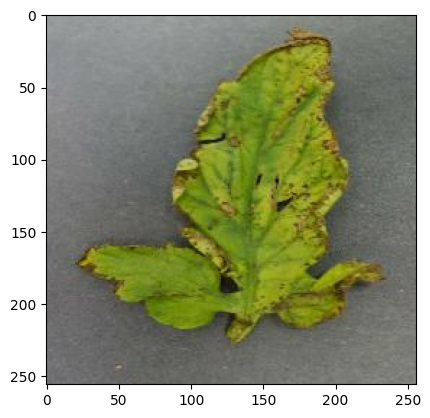

In [57]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0]

print("first image to predict")
plt.imshow(first_image)
print("actual label: ",class_names[first_label])

batch_prediction=model.predict(images_batch)
print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [69]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #create a batch

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 13ms/step


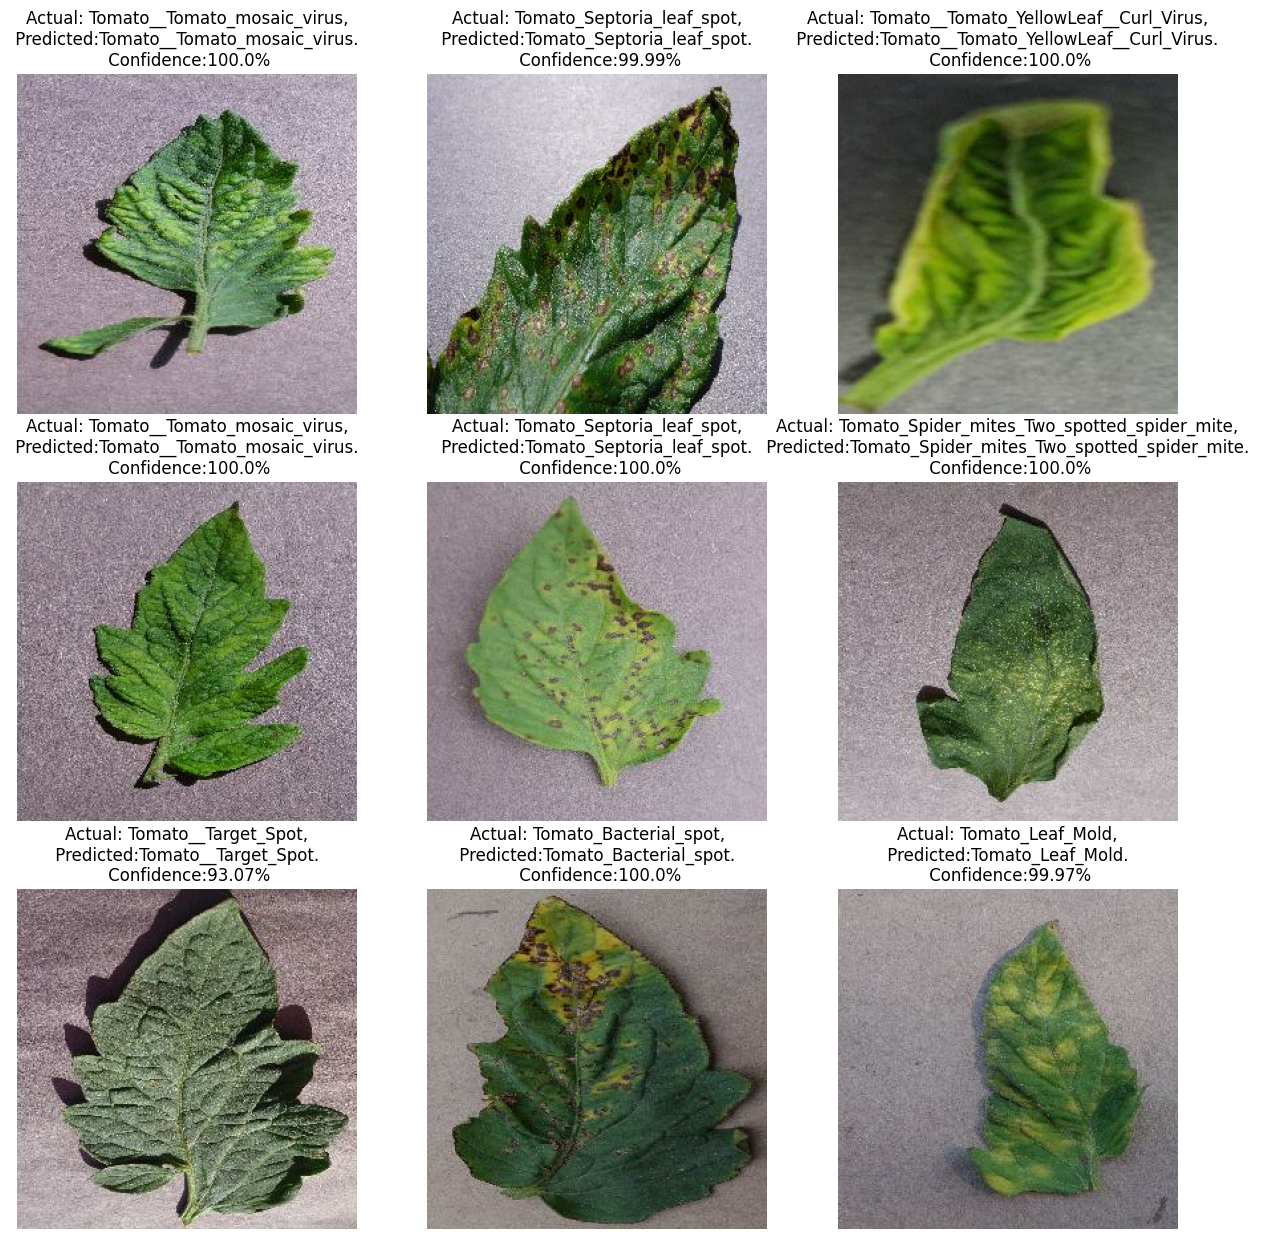

In [72]:
plt.figure(figsize=(15,15))
for images, labels in  test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted:{predicted_class}. \n Confidence:{confidence}%")
        plt.axis("off")

In [73]:
model_version=2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
